In [1]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import json
import os
import re
import contractions
import string
import seaborn as sns
from tabulate import tabulate
from urllib.parse import urljoin  
import pickle as pkl
import community as community_louvain
from collections import Counter
from fa2_modified import ForceAtlas2
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nrclex import NRCLex
from PIL import Image
from rapidfuzz import process

In [2]:
df = pd.read_excel('campaign 1.xlsx')
print(df.head())

                                             text             username
0     @lindsay.slipknot666 j'ai pas les mots 🤤🤣🤣🤣       ameliie.genest
1                 @ameliie.genest juste admire 🤤🤣  lindsay.slipknot666
2  @lindsay.slipknot666 j'ai besoin d'un bavoir 😂       ameliie.genest
3                                        yes chef          linmelendez
4                              I fell to my knees      soonerthelosers


Extracting emojis in a separated column

In [3]:
def extract_emojis(text):
    emoji_pattern = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)
    return ''.join(emoji_pattern.findall(str(text)))

# Apply it to your DataFrame
df['emojis'] = df['text'].apply(extract_emojis)

# Preview result
print(df)

                                                 text             username  \
0         @lindsay.slipknot666 j'ai pas les mots 🤤🤣🤣🤣       ameliie.genest   
1                     @ameliie.genest juste admire 🤤🤣  lindsay.slipknot666   
2      @lindsay.slipknot666 j'ai besoin d'un bavoir 😂       ameliie.genest   
3                                            yes chef          linmelendez   
4                                  I fell to my knees      soonerthelosers   
...                                               ...                  ...   
10076                                             😍🫠🔥            kenitoken   
10077                                         grazie.        flowerysmells   
10078                                      Hermanas..           gisellecan   
10079                                              😮🔥             tortain_   
10080                  THIS VIDEO IS THREE HOURS LONG   wrestlewithwriting   

      emojis  
0       🤤🤣🤣🤣  
1         🤤🤣  
2          😂  
3  

Now, because a lot of rows might be empty or only containing a tag to another person, we decide to drop them

In [4]:
# Function to check if text is empty or contains only mention
def is_empty_or_mention_only(text):
    if pd.isna(text):
        return True
    text = str(text).strip()
    if text == '':
        return True
    # Check if text only contains a mention (@username)
    if re.match(r'^@\w+$', text):
        return True
    return False

# Count empty or mention-only rows
empty_or_mention_count = df['text'].apply(is_empty_or_mention_only).sum()
print(f"Number of empty rows or rows with only mentions: {empty_or_mention_count}")

Number of empty rows or rows with only mentions: 1529


In [5]:
# Drop rows where text is empty or contains only mentions
df = df[~df['text'].apply(is_empty_or_mention_only)]

# Print the new shape of the dataframe to confirm the drop
print(f"Shape after dropping empty/mention-only rows: {df.shape}")

Shape after dropping empty/mention-only rows: (8552, 3)


By doing that, 1529 rows have been eliminated

In [6]:
def clean_text(text):
    text = str(text)    
    text = re.sub(r'@\S+', '', text)  # Remove usernames and any non-whitespace characters after @
    text = re.sub(r'#\w+', '', text)  # Remove hashtags (if any)
    text = re.sub(r'http\S+', '', text)  # Remove links
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)


In [7]:
df

,text,username,emojis,clean_text
0,@lindsay.slipknot666 j'ai pas les mots 🤤🤣🤣🤣,ameliie.genest,🤤🤣🤣🤣,j'ai pas les mots 🤤🤣🤣🤣
1,@ameliie.genest juste admire 🤤🤣,lindsay.slipknot666,🤤🤣,juste admire 🤤🤣
2,@lindsay.slipknot666 j'ai besoin d'un bavoir 😂,ameliie.genest,😂,j'ai besoin d'un bavoir 😂
3,yes chef,linmelendez,,yes chef
4,I fell to my knees,soonerthelosers,,I fell to my knees
...,...,...,...,...
10076,😍🫠🔥,kenitoken,😍🫠🔥,😍🫠🔥
10077,grazie.,flowerysmells,,grazie.
10078,Hermanas..,gisellecan,,Hermanas..
10079,😮🔥,tortain_,😮🔥,😮🔥


In [8]:
def clean_text_extra(text):
    # Make all text strings
    text = str(text)
    
    # Expand contractions (e.g., "I'm" -> "I am")
    text_expanded = contractions.fix(text)
    
    # Lowercase the text
    text_expanded = text_expanded.lower()
    
    # Remove punctuation
    text_nopoints = text_expanded.translate(str.maketrans('', '', string.punctuation))
    
    # Normalize spaces (remove extra whitespace)
    text_nospace = ' '.join(text_nopoints.split())
    
    # Remove stopwords
    stopwords_en = set(stopwords.words('english'))
    words_no_stopword = [word for word in text_nospace.split() if word not in stopwords_en]
    
    # Remove tokens that are not purely alphabetical
    words_no_number = [word for word in words_no_stopword if word.isalpha()]
    
    cleaned_text = ' '.join(words_no_number)
    return cleaned_text
     

In [9]:
# Apply the updated clean_text function to create a new column
df['processed_text'] = df['clean_text'].apply(clean_text_extra)

# Display first few rows to verify
print(df[['text', 'processed_text']].head())

                                             text         processed_text
0     @lindsay.slipknot666 j'ai pas les mots 🤤🤣🤣🤣       jai pas les mots
1                 @ameliie.genest juste admire 🤤🤣           juste admire
2  @lindsay.slipknot666 j'ai besoin d'un bavoir 😂  jai besoin dun bavoir
3                                        yes chef               yes chef
4                              I fell to my knees             fell knees


In [13]:
# Word frequencies
word_counts = Counter(tokenized_df['Word'])
print("Top 20 Words:", word_counts.most_common(20))

# Bigram frequencies
all_bigrams = df['bigrams'].explode()
bigram_counts = Counter(all_bigrams)
print("Top 20 Bigrams:", bigram_counts.most_common(20))

# Trigram frequencies
all_trigrams = df['trigrams'].explode()
trigram_counts = Counter(all_trigrams)
print("Top 20 Trigrams:", trigram_counts.most_common(20))

Top 20 Words: [('yes', 489), ('chef', 429), ('que', 262), ('de', 195), ('rosalia', 190), ('la', 187), ('thank', 178), ('rosalía', 167), ('video', 163), ('calvin', 161), ('te', 144), ('lip', 143), ('like', 141), ('oh', 130), ('god', 130), ('klein', 126), ('el', 113), ('man', 94), ('good', 93), ('times', 90)]
Top 20 Bigrams: [('yes chef', 325), ('calvin klein', 123), ('many times', 53), ('te entiendo', 47), ('que bien', 32), ('la rosalía', 32), ('times watched', 31), ('los hombres', 30), ('vivan los', 30), ('thank calvin', 29), ('que vivan', 28), ('cannot stop', 26), ('lip gallagher', 24), ('la rosalia', 24), ('god bless', 24), ('hours long', 24), ('entiendo rosalia', 23), ('bien come', 22), ('oh god', 20), ('girl dinner', 20)]
Top 20 Trigrams: [('que vivan los', 28), ('vivan los hombres', 27), ('many times watched', 26), ('que bien come', 20), ('te entiendo rosalia', 20), ('thank calvin klein', 20), ('times watched yes', 17), ('video hours long', 16), ('cannot stop watching', 14), ('bie

Is not too late to translate, we will do so in order to keep the output clean an coherent (and also insightful)

In [14]:
def remove_emojis(text):
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002700-\U000027BF"  # dingbats
        u"\U000024C2-\U0001F251"  # other symbols
        "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [15]:
df["text_no_emoji"] = df["processed_text"].apply(remove_emojis)

We extract the emoji in a separate column, to have them ready for future analysis

In [16]:
import emoji

def extract_emojis(text):
    return ''.join(c for c in text if c in emoji.EMOJI_DATA)

df["emojis"] = df["processed_text"].apply(extract_emojis)

In [17]:
df_text = pd.DataFrame(df['text_no_emoji'])

In [18]:
# Drop rows where text_no_emoji is empty or contains only whitespace
df_text = df_text[df_text['text_no_emoji'].str.strip() != '']
print(f"Shape after dropping empty rows: {df_text.shape}")

Shape after dropping empty rows: (6683, 1)


In [19]:
from googletrans import Translator
from langdetect import detect, LangDetectException
import time
from tqdm import tqdm

translator = Translator()

# Step 1: Detect Language
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Step 2: Safe translate with timeout & error catching
def safe_translate(text):
    try:
        cleaned_text = remove_emojis(text)
        result = translator.translate(cleaned_text, dest='en')
        return result.text if result and hasattr(result, 'text') else text
    except Exception as e:
        print(f"Translation error: {e}")
        return text

# Step 3: Apply to only non-English rows, one-by-one with progress bar
def translate_comments(text_list, sleep_time=0.2):
    translated = []
    for text in tqdm(text_list, desc="Translating", unit="comment"):
        translated.append(safe_translate(text))
        time.sleep(sleep_time)  # avoid being rate-limited
    return translated

In [20]:
# Step 1: Detect languages
df_text["lang"] = df_text["text_no_emoji"].apply(detect_language)

# Step 2: Filter only non-English
non_en = df_text[df_text["lang"] != "en"].copy()

# Step 3: Translate with safe loop
non_en["translated_text"] = translate_comments(non_en["text_no_emoji"].tolist(), sleep_time=0.2)

# Step 4: Update back into main df
df_text.update(non_en)

Translating:   5%|▌         | 258/4925 [01:28<27:31,  2.83comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   5%|▌         | 266/4925 [01:32<40:46,  1.90comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   5%|▌         | 267/4925 [01:32<49:54,  1.56comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   5%|▌         | 270/4925 [01:34<41:09,  1.88comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▌         | 282/4925 [01:39<36:35,  2.11comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▌         | 284/4925 [01:40<44:05,  1.75comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▌         | 291/4925 [01:43<36:50,  2.10comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▌         | 292/4925 [01:43<40:31,  1.91comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▌         | 300/4925 [01:46<32:54,  2.34comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▌         | 303/4925 [01:47<28:20,  2.72comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▌         | 307/4925 [01:49<38:41,  1.99comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▋         | 311/4925 [01:51<42:21,  1.82comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▋         | 312/4925 [01:52<50:56,  1.51comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▋         | 317/4925 [01:54<42:00,  1.83comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   6%|▋         | 318/4925 [01:55<44:53,  1.71comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   7%|▋         | 321/4925 [01:57<44:44,  1.71comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   7%|▋         | 326/4925 [01:59<41:17,  1.86comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   7%|▋         | 327/4925 [02:00<47:05,  1.63comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   7%|▋         | 342/4925 [02:05<36:43,  2.08comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   7%|▋         | 347/4925 [02:07<35:57,  2.12comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   8%|▊         | 371/4925 [02:16<25:20,  2.99comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:   8%|▊         | 382/4925 [02:20<34:42,  2.18comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  12%|█▏        | 595/4925 [03:37<33:58,  2.12comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  13%|█▎        | 619/4925 [03:47<34:39,  2.07comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  13%|█▎        | 624/4925 [03:49<34:29,  2.08comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  13%|█▎        | 629/4925 [03:50<25:02,  2.86comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  13%|█▎        | 641/4925 [03:55<35:11,  2.03comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  13%|█▎        | 644/4925 [03:57<38:04,  1.87comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  13%|█▎        | 663/4925 [04:04<36:58,  1.92comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  14%|█▎        | 668/4925 [04:06<33:46,  2.10comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  14%|█▎        | 671/4925 [04:07<27:07,  2.61comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  14%|█▍        | 691/4925 [04:14<33:12,  2.12comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  14%|█▍        | 708/4925 [04:20<24:06,  2.91comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  15%|█▍        | 717/4925 [04:24<33:27,  2.10comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  15%|█▍        | 732/4925 [04:29<27:11,  2.57comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  15%|█▍        | 734/4925 [04:31<43:36,  1.60comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  15%|█▌        | 756/4925 [04:38<23:07,  3.00comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  16%|█▌        | 794/4925 [04:54<23:39,  2.91comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  16%|█▋        | 801/4925 [04:57<32:28,  2.12comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  17%|█▋        | 847/4925 [05:13<31:17,  2.17comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  18%|█▊        | 865/4925 [05:20<31:09,  2.17comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  18%|█▊        | 875/4925 [05:23<29:32,  2.28comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  18%|█▊        | 884/4925 [05:27<30:53,  2.18comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  18%|█▊        | 891/4925 [05:29<31:08,  2.16comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  18%|█▊        | 895/4925 [05:31<24:36,  2.73comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  19%|█▉        | 924/4925 [05:42<33:01,  2.02comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  19%|█▉        | 928/4925 [05:44<25:17,  2.63comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  19%|█▉        | 936/4925 [05:47<22:44,  2.92comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  19%|█▉        | 946/4925 [05:52<36:43,  1.81comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  19%|█▉        | 949/4925 [05:53<35:21,  1.87comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  19%|█▉        | 950/4925 [05:54<41:10,  1.61comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  20%|█▉        | 963/4925 [05:59<30:11,  2.19comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  20%|██        | 993/4925 [06:10<33:07,  1.98comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  20%|██        | 996/4925 [06:11<33:29,  1.95comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  21%|██        | 1030/4925 [06:23<29:20,  2.21comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  21%|██        | 1039/4925 [06:27<33:21,  1.94comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  22%|██▏       | 1072/4925 [06:39<28:25,  2.26comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  22%|██▏       | 1088/4925 [06:44<22:08,  2.89comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  22%|██▏       | 1090/4925 [06:46<34:36,  1.85comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  22%|██▏       | 1092/4925 [06:47<36:36,  1.75comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  24%|██▍       | 1197/4925 [07:24<26:55,  2.31comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  25%|██▍       | 1209/4925 [07:29<30:34,  2.03comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  25%|██▍       | 1213/4925 [07:30<29:38,  2.09comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  25%|██▍       | 1219/4925 [07:33<29:53,  2.07comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  25%|██▌       | 1239/4925 [07:40<27:37,  2.22comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  26%|██▌       | 1265/4925 [07:49<20:44,  2.94comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  26%|██▌       | 1268/4925 [07:50<24:10,  2.52comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  26%|██▌       | 1274/4925 [07:53<30:23,  2.00comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  26%|██▌       | 1285/4925 [07:58<28:11,  2.15comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  26%|██▋       | 1298/4925 [08:03<27:02,  2.23comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  26%|██▋       | 1299/4925 [08:03<30:39,  1.97comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  26%|██▋       | 1302/4925 [08:05<31:38,  1.91comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  27%|██▋       | 1307/4925 [08:07<29:19,  2.06comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  27%|██▋       | 1309/4925 [08:08<34:11,  1.76comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  27%|██▋       | 1337/4925 [08:18<29:48,  2.01comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  27%|██▋       | 1338/4925 [08:19<32:22,  1.85comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  28%|██▊       | 1371/4925 [08:30<29:27,  2.01comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  28%|██▊       | 1386/4925 [08:36<25:46,  2.29comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  28%|██▊       | 1392/4925 [08:39<31:18,  1.88comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  29%|██▊       | 1410/4925 [08:45<28:11,  2.08comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  29%|██▊       | 1414/4925 [08:47<31:27,  1.86comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  29%|██▉       | 1449/4925 [08:59<19:19,  3.00comment/s]

Translation error: 'NoneType' object is not iterable


Translating:  31%|███       | 1528/4925 [09:30<27:43,  2.04comment/s]

Translation error: 'Translator' object has no attribute 'raise_Exception'


Translating:  37%|███▋      | 1798/4925 [12:33<54:28,  1.05s/comment]  

Translation error: the JSON object must be str, bytes or bytearray, not NoneType


Translating:  48%|████▊     | 2348/4925 [18:13<39:21,  1.09comment/s]  

Translation error: the JSON object must be str, bytes or bytearray, not NoneType


Translating:  60%|██████    | 2974/4925 [25:19<14:00,  2.32comment/s]

Translation error: sequence item 0: expected str instance, NoneType found


Translating:  87%|████████▋ | 4308/4925 [39:15<04:40,  2.20comment/s]

Translation error: the JSON object must be str, bytes or bytearray, not NoneType


Translating: 100%|██████████| 4925/4925 [45:57<00:00,  1.79comment/s]


In [21]:
df_text

,text_no_emoji,lang
0,jai pas les mots,lv
1,juste admire,et
2,jai besoin dun bavoir,fi
3,yes chef,en
4,fell knees,no
...,...,...
10070,guess hour long dissection video,en
10075,rosalia knows things,en
10077,grazie,pl
10078,hermanas,en


In [22]:
non_en 

,text_no_emoji,lang,translated_text
0,jai pas les mots,lv,I don't have the words
1,juste admire,et,just admire
2,jai besoin dun bavoir,fi,I need a bib
4,fell knees,no,fell knees
8,today,so,today
...,...,...,...
10062,lo que se anda comiendo la rosalía,es,What is eating the Rosalia
10063,wow,pl,wow
10068,pero carmi let us cook,it,pero carmi let us cook
10069,great start day,sv,great start day


In [24]:
non_en.to_csv('non_en.csv', index=False)

In [ ]:
df_text = pd.concat([df_text, non_en], axis=1)
print(df_text.head())

           text_no_emoji lang          text_no_emoji lang  \
0       jai pas les mots   lv       jai pas les mots   lv   
1           juste admire   et           juste admire   et   
2  jai besoin dun bavoir   fi  jai besoin dun bavoir   fi   
3               yes chef   en                    NaN  NaN   
4             fell knees   no             fell knees   no   

          translated_text  
0  I don't have the words  
1             just admire  
2            I need a bib  
3                     NaN  
4              fell knees  


In [27]:
# Drop duplicate columns (columns 3 and 4)
df_text = df_text.iloc[:, [0, 1, 4]]  # Keep only columns 0, 1, and 4 (text_no_emoji, lang, translated_text)
print(df_text.head())

           text_no_emoji lang         translated_text
0       jai pas les mots   lv  I don't have the words
1           juste admire   et             just admire
2  jai besoin dun bavoir   fi            I need a bib
3               yes chef   en                     NaN
4             fell knees   no              fell knees


In [28]:
df_text['translated_text'] = df_text.apply(
    lambda row: row['text_no_emoji'] if pd.isna(row['translated_text']) else row['translated_text'], axis=1
)

C:\Users\nba\AppData\Local\Temp\ipykernel_18944\3619673221.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text['translated_text'] = df_text.apply(


In [31]:
df_text.to_csv('df_text.csv', index=False)

In [32]:
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

df_text["sentiment_score"] = df_text["translated_text"].apply(lambda x: sid.polarity_scores(x)["compound"])

df_text["sentiment_label"] = df_text["sentiment_score"].apply(
    lambda x: "positive" if x > 0.05 else ("negative" if x < -0.05 else "neutral")
)

# Quick stats
print(df_text["sentiment_label"].value_counts())

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nba\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment_label
neutral     3420
positive    2670
negative     593
Name: count, dtype: int64


C:\Users\nba\AppData\Local\Temp\ipykernel_18944\2718280070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_text["sentiment_score"] = df_text["translated_text"].apply(lambda x: sid.polarity_scores(x)["compound"])


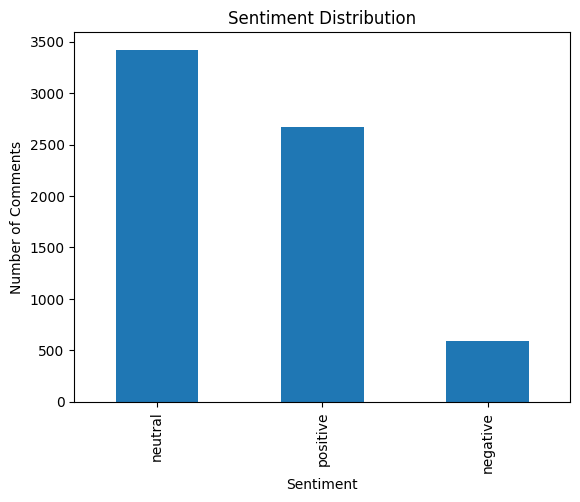

In [34]:
df_text["sentiment_label"].value_counts().plot(kind="bar", title="Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.show()


In [53]:
df_text = df_text.drop(columns=['ngrams', 'bigrams', 'trigrams'])

In [48]:
df_text

,text_no_emoji,lang,translated_text,sentiment_score,sentiment_label,final_text
0,jai pas les mots,lv,I don't have the words,0.0000,neutral,I don't have the words
1,juste admire,et,just admire,0.4767,positive,just admire
2,jai besoin dun bavoir,fi,I need a bib,0.0000,neutral,I need a bib
3,yes chef,en,yes chef,0.4019,positive,yes chef
4,fell knees,no,fell knees,0.0000,neutral,fell knees
...,...,...,...,...,...,...
10070,guess hour long dissection video,en,guess hour long dissection video,0.0000,neutral,guess hour long dissection video
10075,rosalia knows things,en,rosalia knows things,0.0000,neutral,rosalia knows things
10077,grazie,pl,Thank you,0.3612,positive,Thank you
10078,hermanas,en,hermanas,0.0000,neutral,hermanas


In [55]:
# N-gram processing function
def process_text(text):
    cleaned_text = clean_text(text)

    unigrams = cleaned_text.split()

    bigrams = [
        unigrams[i] + ' ' + unigrams[i + 1]
        for i in range(len(unigrams) - 1)
    ]

    trigrams = [
        unigrams[i] + ' ' + unigrams[i + 1] + ' ' + unigrams[i + 2]
        for i in range(len(unigrams) - 2)
    ]

    return {'bigrams': bigrams, 'trigrams': trigrams}

# Step 1: Clean translated text (basic cleaning)
df_text["cleaned"] = df_text["translated_text"].apply(clean_text)

# Step 2: Generate n-grams from cleaned text
df_text["ngrams"] = df_text["cleaned"].apply(process_text)
df_text["bigrams"] = df_text["ngrams"].apply(lambda x: x["bigrams"])
df_text["trigrams"] = df_text["ngrams"].apply(lambda x: x["trigrams"])

# Step 3: Extra text cleanup
df_text["final_text"] = df_text["cleaned"].apply(clean_text_extra)

# Step 4: Tokenization — works even if 'username' is not the index
def tokenize_words(df):  
    df['Tokens'] = df['final_text'].apply(nltk.word_tokenize)
    
    # Check if 'username' is in columns before exploding
    cols = ['Tokens']
    if 'username' in df.columns:
        cols = ['username', 'Tokens']
    
    tokenized_df = df[cols].explode('Tokens').rename(columns={'Tokens': 'Word'})
    return tokenized_df

# Run it
tokenized_df = tokenize_words(df_text)

In [56]:
df_text

,text_no_emoji,lang,translated_text,sentiment_score,sentiment_label,final_text,cleaned,Tokens,ngrams,bigrams,trigrams
0,jai pas les mots,lv,I don't have the words,0.0000,neutral,words,I don't have the words,[words],"{'bigrams': ['I don't', 'don't have', 'have th...","[I don't, don't have, have the, the words]","[I don't have, don't have the, have the words]"
1,juste admire,et,just admire,0.4767,positive,admire,just admire,[admire],"{'bigrams': ['just admire'], 'trigrams': []}",[just admire],[]
2,jai besoin dun bavoir,fi,I need a bib,0.0000,neutral,need bib,I need a bib,"[need, bib]","{'bigrams': ['I need', 'need a', 'a bib'], 'tr...","[I need, need a, a bib]","[I need a, need a bib]"
3,yes chef,en,yes chef,0.4019,positive,yes chef,yes chef,"[yes, chef]","{'bigrams': ['yes chef'], 'trigrams': []}",[yes chef],[]
4,fell knees,no,fell knees,0.0000,neutral,fell knees,fell knees,"[fell, knees]","{'bigrams': ['fell knees'], 'trigrams': []}",[fell knees],[]
...,...,...,...,...,...,...,...,...,...,...,...
10070,guess hour long dissection video,en,guess hour long dissection video,0.0000,neutral,guess hour long dissection video,guess hour long dissection video,"[guess, hour, long, dissection, video]","{'bigrams': ['guess hour', 'hour long', 'long ...","[guess hour, hour long, long dissection, disse...","[guess hour long, hour long dissection, long d..."
10075,rosalia knows things,en,rosalia knows things,0.0000,neutral,rosalia knows things,rosalia knows things,"[rosalia, knows, things]","{'bigrams': ['rosalia knows', 'knows things'],...","[rosalia knows, knows things]",[rosalia knows things]
10077,grazie,pl,Thank you,0.3612,positive,thank,Thank you,[thank],"{'bigrams': ['Thank you'], 'trigrams': []}",[Thank you],[]
10078,hermanas,en,hermanas,0.0000,neutral,hermanas,hermanas,[hermanas],"{'bigrams': [], 'trigrams': []}",[],[]


In [88]:
# Rename the first column (column 1) to 'username'
tokenized_df.rename(columns={tokenized_df.columns[0]: 'Word'}, inplace=True)

In [90]:
tokenized_df.index.name = 'username'

In [91]:
tokenized_df 


,Word,nrc_emotions
username,,
0,words,"[anger, negative]"
1,admire,"[positive, trust]"
2,need,[]
2,bib,[]
3,yes,[]
...,...,...
10078,hermanas,[]
10080,video,[]
10080,three,[]


## BI and Trigrams

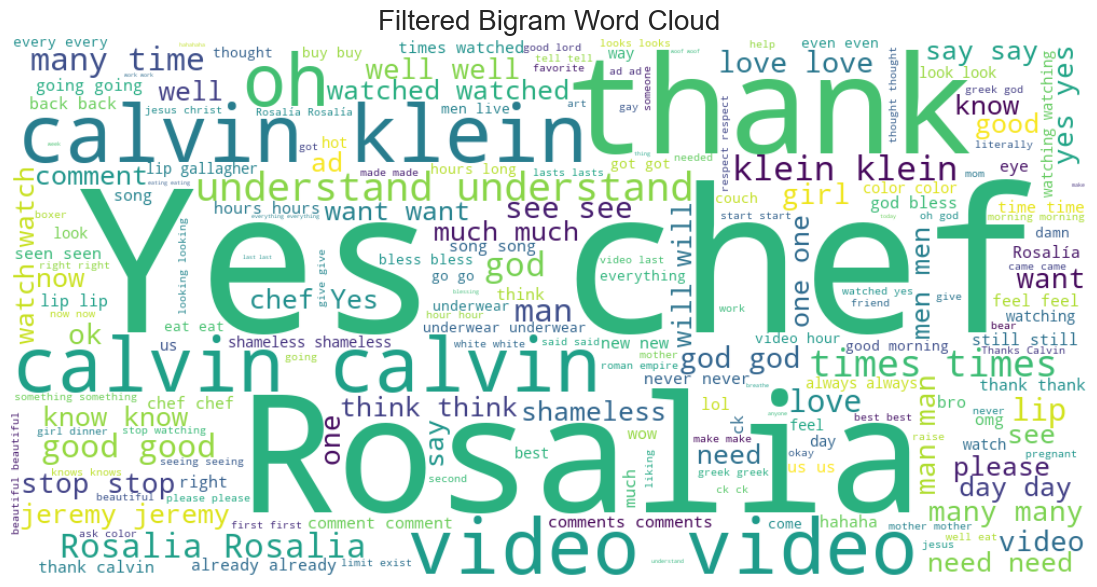

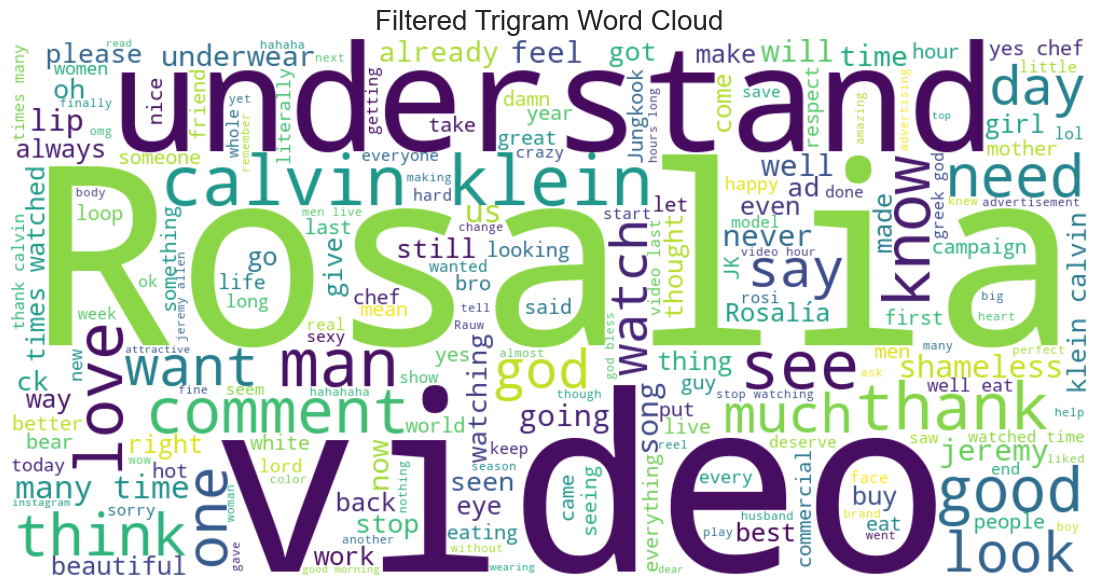

In [81]:
# ✅ Filter and build clean bigram/trigram strings
filtered_bigrams_text = ' '.join(
    bg for bg in df_text['bigrams'].explode().dropna().astype(str)
    if len(bg.split()) == 2
)

filtered_trigrams_text = ' '.join(
    tg for tg in df_text['trigrams'].explode().dropna().astype(str)
    if len(tg.split()) == 3
)

# ✅ Create WordClouds
filtered_bigram_wc = WordCloud(width=1000, height=500, background_color='white').generate(filtered_bigrams_text)
filtered_trigram_wc = WordCloud(width=1000, height=500, background_color='white').generate(filtered_trigrams_text)

# ✅ Plot Clean Bigram Word Cloud
plt.figure(figsize=(14, 7))
plt.title("Filtered Bigram Word Cloud", fontsize=20)
plt.imshow(filtered_bigram_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

# ✅ Plot Clean Trigram Word Cloud
plt.figure(figsize=(14, 7))
plt.title("Filtered Trigram Word Cloud", fontsize=20)
plt.imshow(filtered_trigram_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Unigrams

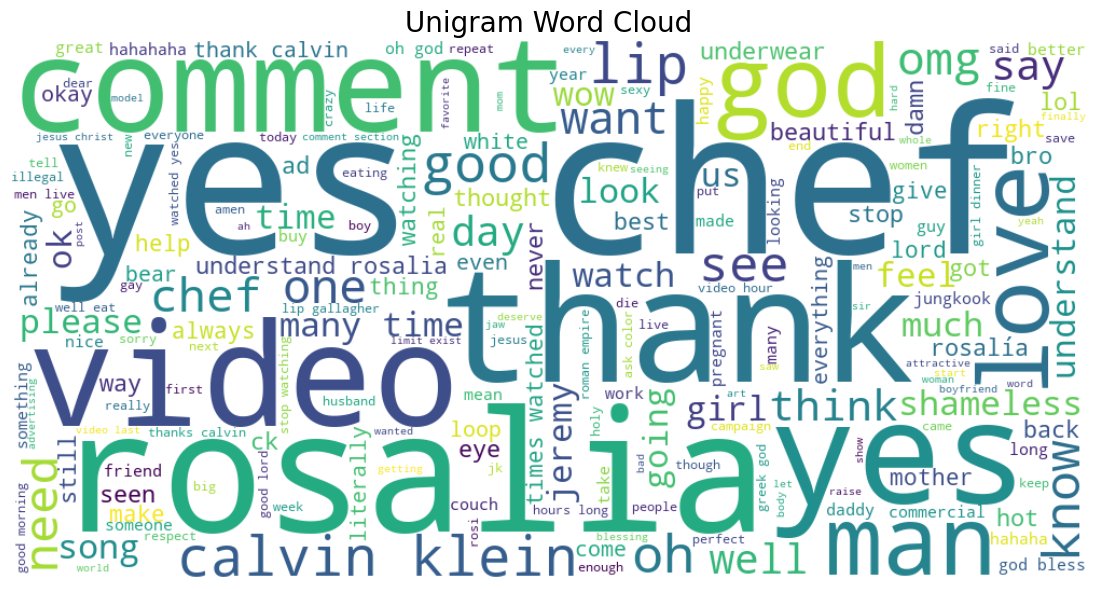

In [59]:
# Join all tokens into a single string
unigrams_text = ' '.join(tokenized_df['Word'].dropna().astype(str))

# Generate WordCloud
unigram_wc = WordCloud(width=1000, height=500, background_color='white').generate(unigrams_text)

# Plot it
plt.figure(figsize=(14, 7))
plt.title("Unigram Word Cloud", fontsize=20)
plt.imshow(unigram_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

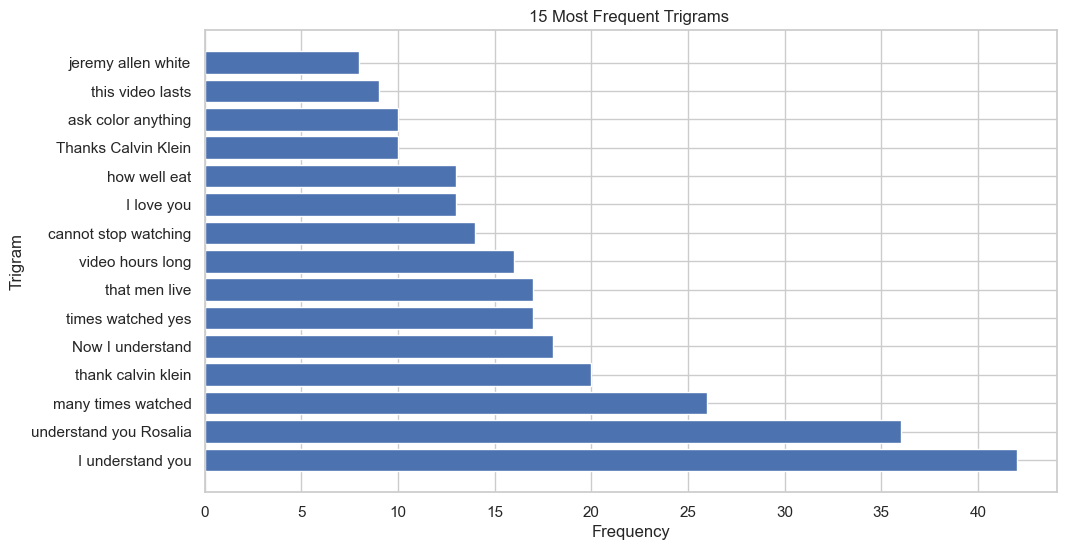

In [98]:
trigram_freq = FreqDist([tg for row in df_text['trigrams'] for tg in row])

# 15 trigrams more frequent
frequent_trigrams = trigram_freq.most_common(15)

plt.figure(figsize=(11, 6))
plt.barh([x[0] for x in frequent_trigrams], [x[1] for x in frequent_trigrams])
plt.title("15 Most Frequent Trigrams ")
plt.xlabel("Frequency")
plt.ylabel("Trigram")
plt.show()

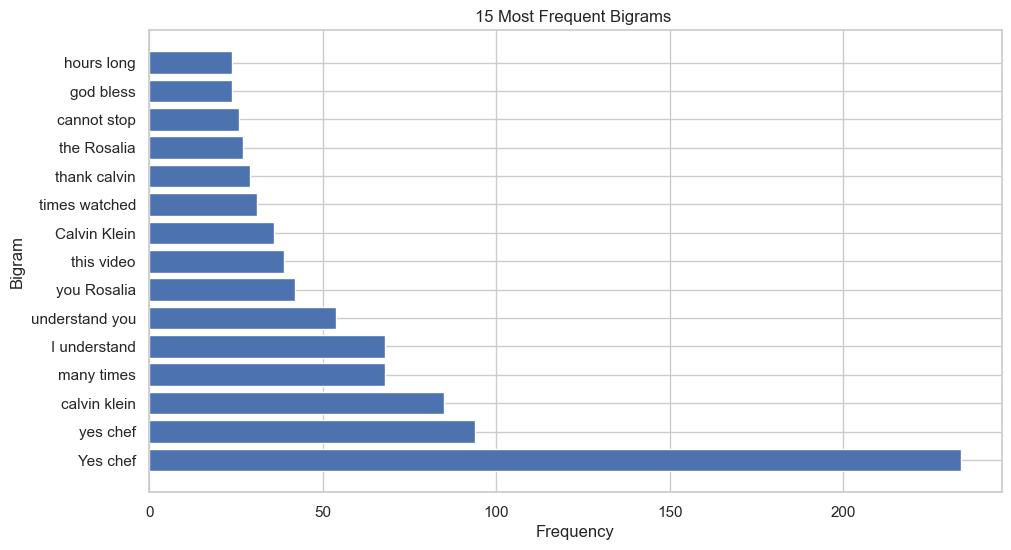

In [99]:
bigram_freq = FreqDist([bg for row in df_text['bigrams'] for bg in row])

# 15 bigramas more frequent
frequent_bigrams = bigram_freq.most_common(15)

plt.figure(figsize=(11, 6))
plt.barh([x[0] for x in frequent_bigrams], [x[1] for x in frequent_bigrams])
plt.title("15 Most Frequent Bigrams ")
plt.xlabel("Frequency")
plt.ylabel("Bigram")
plt.show()

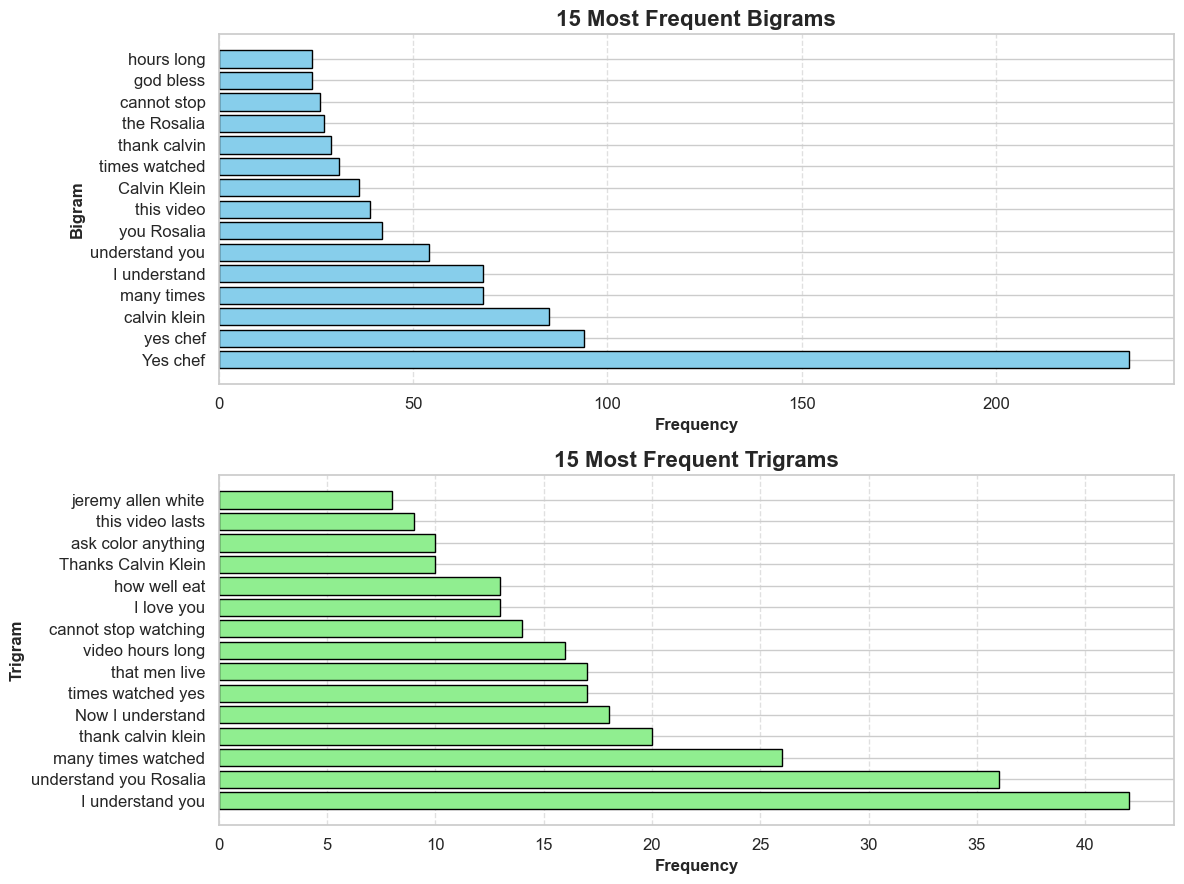

In [100]:
# frequency distribution for bigrams
bigram_freq = FreqDist([bg for row in df_text['bigrams'] for bg in row])

# 15 most frequent bigrams
frequent_bigrams = bigram_freq.most_common(15)

# frequency distribution for trigrams
trigram_freq = FreqDist([tg for row in df_text['trigrams'] for tg in row])

# 15 most frequent trigrams
frequent_trigrams = trigram_freq.most_common(15)

# Create the subplots (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 9))

# Plot the bigrams on the first subplot
ax1.barh([x[0] for x in frequent_bigrams], [x[1] for x in frequent_bigrams], color='skyblue', edgecolor='black')
ax1.set_title("15 Most Frequent Bigrams", fontsize=16, fontweight='bold')
ax1.set_xlabel("Frequency", fontsize=12, fontweight='bold')
ax1.set_ylabel("Bigram", fontsize=12, fontweight='bold')
ax1.grid(axis='x', linestyle='--', alpha=0.6)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_facecolor('white')

# Plot the trigrams on the second subplot
ax2.barh([x[0] for x in frequent_trigrams], [x[1] for x in frequent_trigrams], color='lightgreen', edgecolor='black')
ax2.set_title("15 Most Frequent Trigrams", fontsize=16, fontweight='bold')
ax2.set_xlabel("Frequency", fontsize=12, fontweight='bold')
ax2.set_ylabel("Trigram", fontsize=12, fontweight='bold')
ax2.grid(axis='x', linestyle='--', alpha=0.6)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_facecolor('white')

# Adjust layout for better spacing between subplots (vertical space)
plt.subplots_adjust(hspace=0.3)  # Adjust the space between subplots (vertical)

# Show the plot
plt.tight_layout()
plt.show()


In [71]:
from nrclex import NRCLex

def get_nrc_emotions_nrclex(word):
    try:
        emotion_obj = NRCLex(word)
        return list(emotion_obj.raw_emotion_scores.keys())
    except:
        return []

tokenized_df['nrc_emotions'] = tokenized_df['Word'].apply(get_nrc_emotions_nrclex)

In [72]:
tokenized_df['nrc_emotions'].explode().value_counts()


nrc_emotions
positive        1935
joy             1248
trust           1246
anticipation    1191
negative         815
fear             630
sadness          444
surprise         434
anger            401
disgust          394
Name: count, dtype: int64

In [73]:
emotion_words = tokenized_df.explode('nrc_emotions')
top_by_emotion = emotion_words.groupby('nrc_emotions')['Word'].value_counts().groupby(level=0).head(5)
print(top_by_emotion)


nrc_emotions  Word     
anger         damn          46
              hot           46
              bear          29
              bad           21
              illegal       19
anticipation  god          205
              good         160
              watch         63
              long          57
              time          55
disgust       shameless     72
              lord          54
              damn          46
              bad           21
              illegal       19
fear          god          205
              watch         63
              bear          29
              bad           21
              illegal       19
joy           god          205
              good         160
              love         132
              beautiful     41
              white         41
negative      shameless     72
              lord          54
              damn          46
              mother        37
              bad           21
positive      god          205
              g

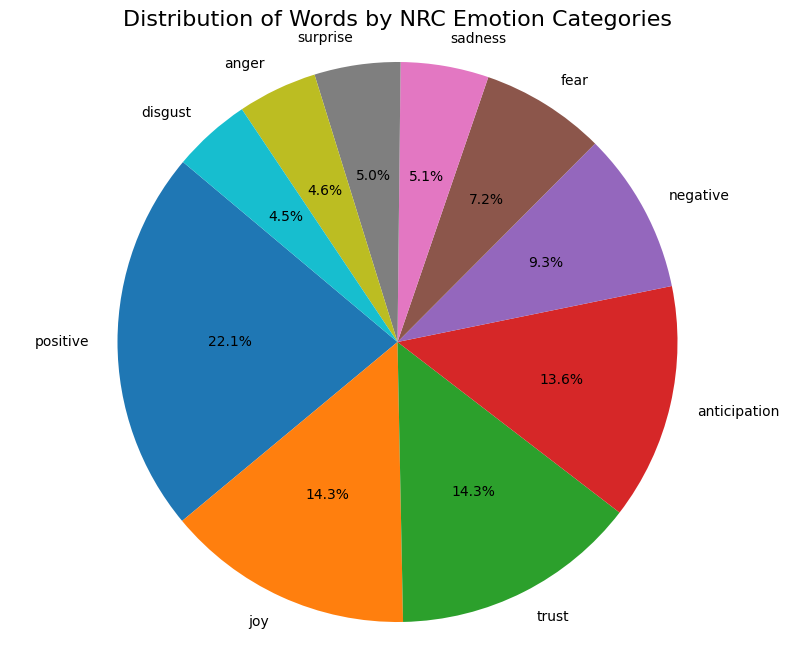

In [74]:
emotion_counts = tokenized_df['nrc_emotions'].explode().value_counts()

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Distribution of Words by NRC Emotion Categories", fontsize=16)
plt.axis('equal')  # Keeps pie circular
plt.show()

In [75]:
emotion_words = tokenized_df.explode('nrc_emotions')

# Group by emotion and count word frequencies
top_by_emotion = (
    emotion_words
    .groupby('nrc_emotions')['Word']
    .value_counts()
    .groupby(level=0)
    .head(10)  # Top 10 words per emotion
)

# Reset index for a clean DataFrame
top_by_emotion = top_by_emotion.reset_index(name='count')
top_by_emotion.columns = ['Emotion', 'Word', 'Count']

In [76]:
print(top_by_emotion)

# Or pivot to see more easily (optional)
pivot_table = top_by_emotion.pivot(index='Word', columns='Emotion', values='Count').fillna(0)

   Emotion     Word  Count
0    anger     damn     46
1    anger      hot     46
2    anger     bear     29
3    anger      bad     21
4    anger  illegal     19
..     ...      ...    ...
95   trust    bless     35
96   trust    happy     34
97   trust     real     31
98   trust   friend     24
99   trust     amen     23

[100 rows x 3 columns]


C:\Users\nba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\nba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
C:\Users\nba\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and wil

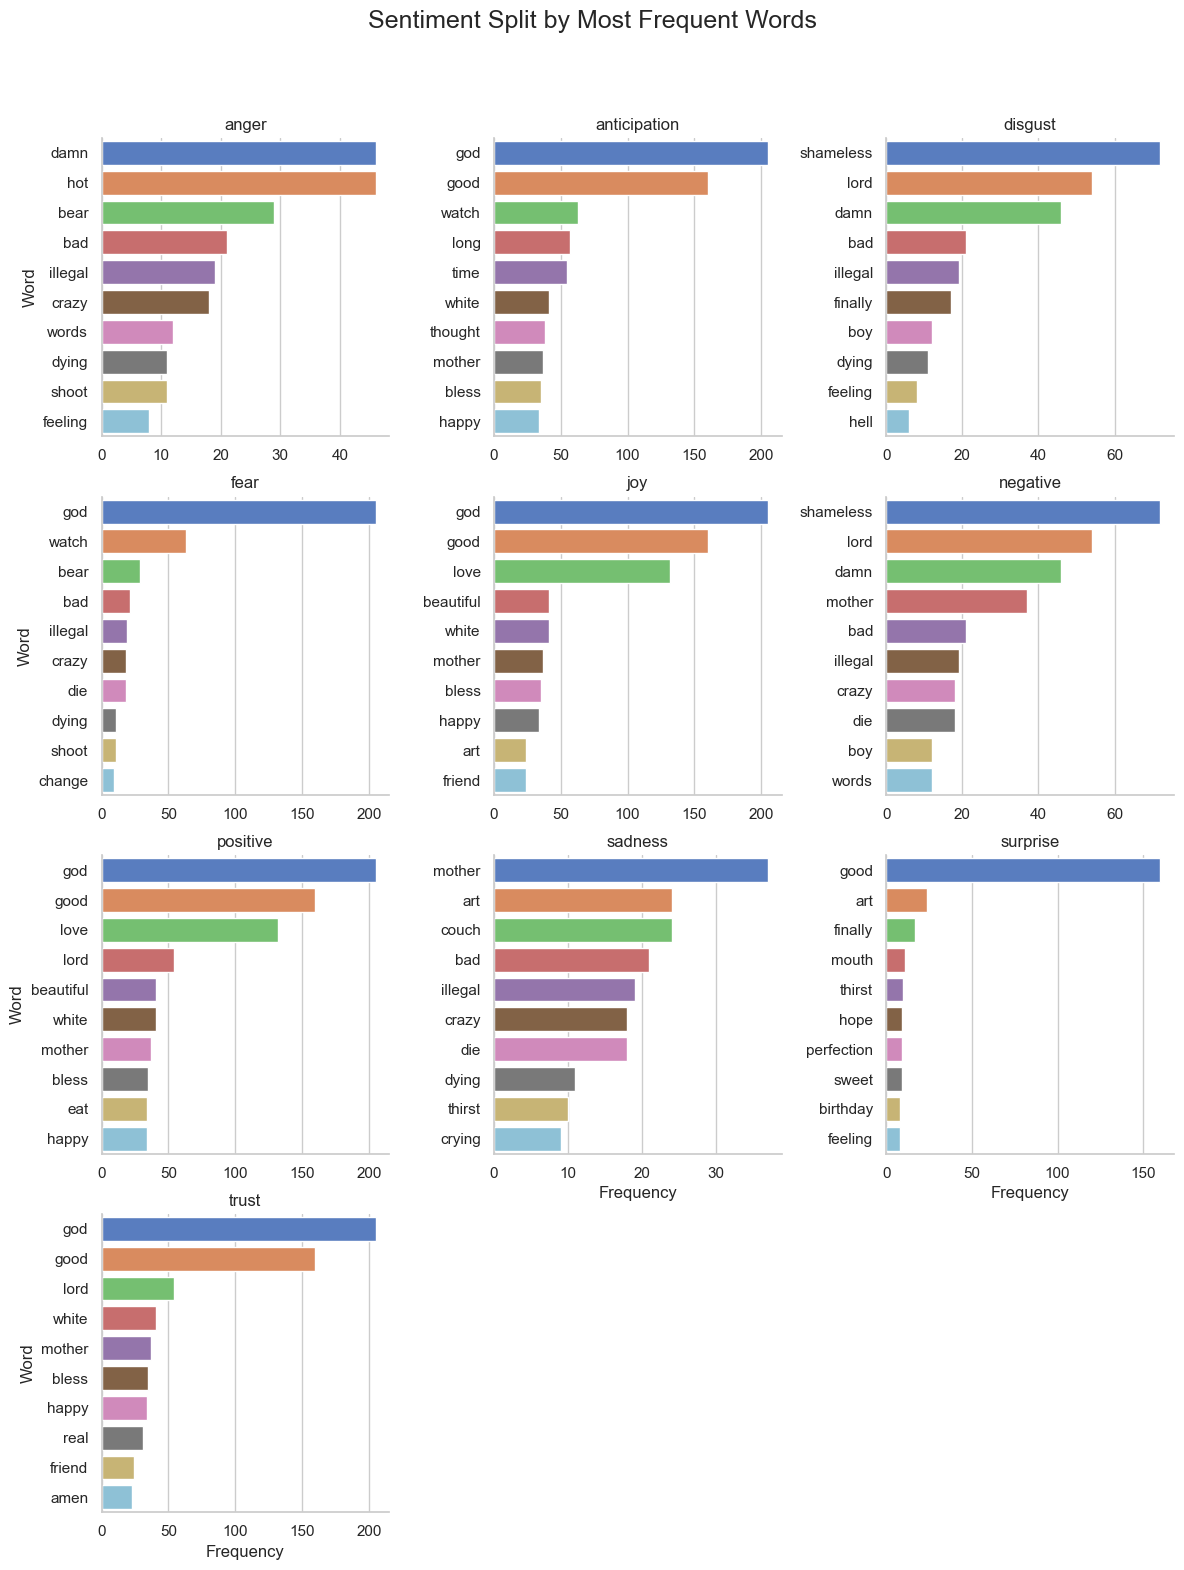

In [77]:
# Optional: Sort for better bar ordering
top_by_emotion_sorted = (
    top_by_emotion.sort_values(["Emotion", "Count"], ascending=[True, False])
)

# Plot settings
sns.set(style="whitegrid")
palette = sns.color_palette("tab10", n_colors=10)

# Create FacetGrid
g = sns.FacetGrid(
    top_by_emotion_sorted, 
    col="Emotion", 
    col_wrap=3, 
    height=4, 
    sharex=False,
    sharey=False
)

# Draw barplot on each facet
g.map_dataframe(
    sns.barplot, 
    x="Count", 
    y="Word", 
    palette="muted"
)

# Titles and labels
g.set_titles("{col_name}")
g.set_axis_labels("Frequency", "Word")

# Overall title
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Sentiment Split by Most Frequent Words", fontsize=18)

# Show the plot
plt.show()